# Kapitel 6.6: Zeiten

Das Notebook ergänzt Kapitel 6.6 'Zeiten'.

# Import

In [1]:
import pandas as pd
import numpy as np

from resources_statistics import *
from resources_geschichtslyrik import *

import plotly.express as px
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator

from tqdm.notebook import tqdm

In [2]:
meta = pd.read_json(r"../resources/meta.json")

# Merkmale hinzufügen

In [3]:
meta['zeit_mitte'] = [(x+y)/2 if pd.notna(x) and pd.notna(y) else float('NaN') for x, y in zip(meta['beginn'], meta['ende'])]
meta['dekade_mitte'] = [(x//10)*10 if pd.notna(x) else float('NaN') for x in meta['zeit_mitte']]
meta['jahrhundert_mitte'] = [(x//100)*100 if pd.notna(x) else float('NaN') for x in meta['zeit_mitte']]

# Korpora

### Korpora erstellen

In [4]:
meta_anth = (
    meta
    .query("corpus=='anth'")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)
meta_anth_bin = binarize_meta(meta_anth)

In [5]:
modcanon_authors = ['Hofmannsthal, Hugo von', 'Rilke, Rainer Maria', 'George, Stefan', 'Heym, Georg']

meta_modcanon = (
    meta
    .query("author in @modcanon_authors")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)

In [6]:
muench_authors = ['Münchhausen, Börries von', 'Miegel, Agnes', 'Strauß und Torney, Lulu von']

meta_muench = (
    meta
    .query("author in @muench_authors")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)

In [7]:
sub_df = pd.DataFrame()
sub_names = ['Anthologien', 'Kanonisierte Moderne', 'Münchhausen-Kreis']
sub_metas = [meta_anth, meta_modcanon, meta_muench]

### Merkmale berechnen

In [8]:
for this_name, this_meta in zip(sub_names, sub_metas):
    sub_df.loc[this_name, 'Jahr'] = round(this_meta['year'].mean(), 0)
    sub_df.loc[this_name, 'Texte'] = this_meta.shape[0]

    sub_df.loc[this_name, '1_zeitebene'] = this_meta.query("zeitebenen == 1").shape[0]/this_meta.shape[0]
    sub_df.loc[this_name, '2_zeitebene'] = this_meta.query("zeitebenen == 2").shape[0]/this_meta.shape[0]
    sub_df.loc[this_name, '3_zeitebene'] = this_meta.query("zeitebenen == 3").shape[0]/this_meta.shape[0]
    sub_df.loc[this_name, '4_zeitebene'] = this_meta.query("zeitebenen >= 4").shape[0]/this_meta.shape[0] 
    sub_df.loc[this_name, 'zeitebenen_per_text'] = this_meta['zeitebenen'].mean() 

    sub_df.loc[this_name, 'antike'] = this_meta.query("zeit_mitte <= 499").shape[0]/this_meta.shape[0] 
    sub_df.loc[this_name, 'mittelalter'] = this_meta.query("500 <= zeit_mitte <= 1499").shape[0]/this_meta.shape[0] 
    sub_df.loc[this_name, 'neuzeit'] = this_meta.query("zeit_mitte >= 1500").shape[0]/this_meta.shape[0] 
    
    sub_df.loc[this_name, 'fixierbarkeit'] = this_meta.query("fixierbarkeit == 1").shape[0]/this_meta.shape[0] 
    sub_df.loc[this_name, 'gegenwartsbezug'] = this_meta.query("gegenwartsbezug == 1").shape[0]/this_meta.shape[0] 
    sub_df.loc[this_name, 'gegenwartsdominanz'] = this_meta.query("vergangenheitsdominant == 0").shape[0]/this_meta.shape[0] 

In [9]:
round(sub_df, 2)

,Jahr,Texte,1_zeitebene,2_zeitebene,3_zeitebene,4_zeitebene,zeitebenen_per_text,antike,mittelalter,neuzeit,fixierbarkeit,gegenwartsbezug,gegenwartsdominanz
Anthologien,1875.0,1850.0,0.28,0.46,0.20,0.05,2.03,0.13,0.32,0.54,0.64,0.29,0.14
Kanonisierte Moderne,1903.0,113.0,0.47,0.44,0.07,0.02,1.64,0.26,0.21,0.53,0.45,0.21,0.12
Münchhausen-Kreis,1905.0,140.0,0.26,0.49,0.16,0.09,2.10,0.05,0.31,0.63,0.48,0.19,0.08


# Zeitverlauf

In [10]:
ts = pd.DataFrame()
ts.index = pd.Series(range(1850, 1919), name = 'year')

In [11]:
ts['text_count'] = meta_anth.groupby('year').size()
ts['text_count'] = ts['text_count'].fillna(0)
ts['text_sum'] = smooth(ts['text_count'], mode = 'sum')

In [12]:
ts['1_zeitebene_count'] = [meta_anth.query("year == @x and zeitebenen == 1").shape[0] for x in ts.index]
ts['1_zeitebene_sum'] = smooth(ts['1_zeitebene_count'], mode = 'sum')
ts['1_zeitebene_share_smoothed'] = ts['1_zeitebene_sum']/ts['text_sum']

ts['2_zeitebene_count'] = [meta_anth.query("year == @x and zeitebenen == 2").shape[0] for x in ts.index]
ts['2_zeitebene_sum'] = smooth(ts['2_zeitebene_count'], mode = 'sum')
ts['2_zeitebene_share_smoothed'] = ts['2_zeitebene_sum']/ts['text_sum']

ts['3_zeitebene_count'] = [meta_anth.query("year == @x and zeitebenen == 3").shape[0] for x in ts.index]
ts['3_zeitebene_sum'] = smooth(ts['3_zeitebene_count'], mode = 'sum')
ts['3_zeitebene_share_smoothed'] = ts['3_zeitebene_sum']/ts['text_sum']

ts['4_zeitebene_count'] = [meta_anth.query("year == @x and zeitebenen >= 4").shape[0] for x in ts.index]
ts['4_zeitebene_sum'] = smooth(ts['4_zeitebene_count'], mode = 'sum')
ts['4_zeitebene_share_smoothed'] = ts['4_zeitebene_sum']/ts['text_sum']

ts['zeitebenen_count'] = [meta_anth.query("year == @x")['zeitebenen'].sum() for x in ts.index]
ts['zeitebenen_sum'] = smooth(ts['zeitebenen_count'], mode = 'sum')
ts['zeitebenen_per_text_smoothed'] = ts['zeitebenen_sum']/ts['text_sum']

ts['antike_count'] = [meta_anth.query("year == @x and zeit_mitte <= 499").shape[0] for x in ts.index]
ts['antike_sum'] = smooth(ts['antike_count'], mode = 'sum')
ts['antike_share_smoothed'] = ts['antike_sum']/ts['text_sum']

ts['mittelalter_count'] = [meta_anth.query("year == @x and 500 <= zeit_mitte <= 1499").shape[0] for x in ts.index]
ts['mittelalter_sum'] = smooth(ts['mittelalter_count'], mode = 'sum')
ts['mittelalter_share_smoothed'] = ts['mittelalter_sum']/ts['text_sum']

ts['neuzeit_count'] = [meta_anth.query("year == @x and zeit_mitte >= 1500").shape[0] for x in ts.index]
ts['neuzeit_sum'] = smooth(ts['neuzeit_count'], mode = 'sum')
ts['neuzeit_share_smoothed'] = ts['neuzeit_sum']/ts['text_sum']

ts['fixierbar_count'] = [meta_anth.query("year == @x and fixierbarkeit == 1").shape[0] for x in ts.index]
ts['fixierbar_sum'] = smooth(ts['fixierbar_count'], mode = 'sum')
ts['fixierbar_share_smoothed'] = ts['fixierbar_sum']/ts['text_sum']

ts['gegenwartsbezug_count'] = [meta_anth.query("year == @x and gegenwartsbezug == 1").shape[0] for x in ts.index]
ts['gegenwartsbezug_sum'] = smooth(ts['gegenwartsbezug_count'], mode = 'sum')
ts['gegenwartsbezug_share_smoothed'] = ts['gegenwartsbezug_sum']/ts['text_sum']

ts['gegenwartsdominanz_count'] = [meta_anth.query("year == @x and vergangenheitsdominant == 0").shape[0] for x in ts.index]
ts['gegenwartsdominanz_sum'] = smooth(ts['gegenwartsdominanz_count'], mode = 'sum')
ts['gegenwartsdominanz_share_smoothed'] = ts['gegenwartsdominanz_sum']/ts['text_sum']

# Anzahl

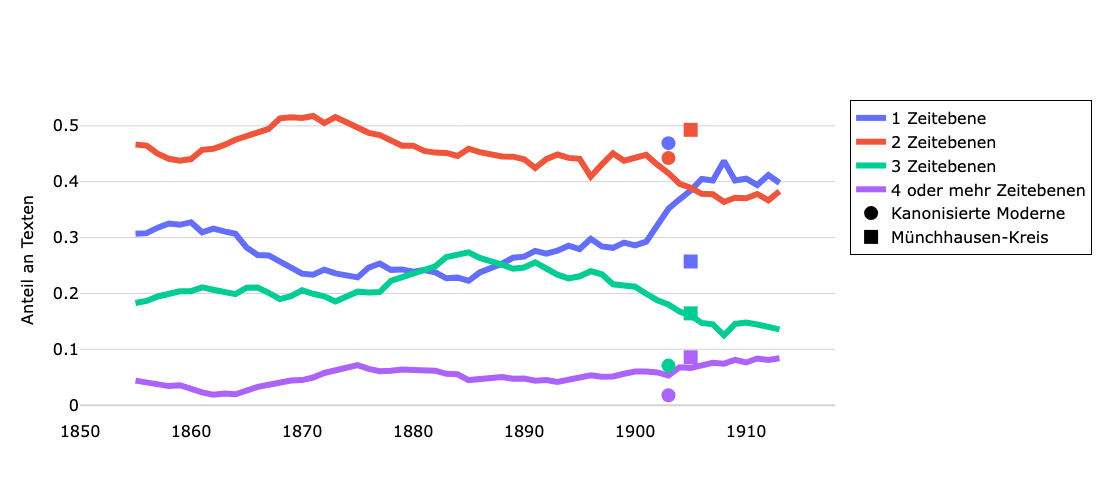

In [59]:
meta_plot = ts[[
    '1_zeitebene_share_smoothed', 
    '2_zeitebene_share_smoothed', 
    '3_zeitebene_share_smoothed',
    '4_zeitebene_share_smoothed'
]]
meta_plot.columns = [
    '1 Zeitebene', 
    '2 Zeitebenen', 
    '3 Zeitebenen',
    '4 oder mehr Zeitebenen'
]
# save_ts_data(meta_plot, prefix='06_06_Anzahl_Zeitebenen_')

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil an Texten',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['1_zeitebene', '2_zeitebene', '3_zeitebene', '4_zeitebene']
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/6.6 Anzahl Zeitebenen im Zeitverlauf.pdf")
fig.show()

In [14]:
meta_plot = ts[['zeitebenen_per_text_smoothed', 
]]
meta_plot.columns = ['Anthologiekorpus']

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Zeitebenen pro Text (Mittelwert)',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['zeitebenen_per_text']
)
fig.show()

In [15]:
main_feature = 'zeitebenen'

In [16]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = False).head(20)

zeitebenen                              1.000000
zeitmarker_vorhanden                    0.379343
gegenwartsbezug                         0.345756
liebe_positiv                           0.310905
marker_count                            0.294403
geschichtsauffassung_positiv            0.268621
ueberlieferung                          0.240563
sprechinstanz_nicht_in_vergangenheit    0.227481
words                                   0.218655
nationalismus                           0.208573
gegenwartsdominant                      0.205095
sprechinstanz_markiert                  0.172428
praesens_praeteritum_vorhanden          0.162247
nation_volk_d                           0.139624
sprechakte_count                        0.134375
stoffgebiet_count                       0.132739
zustand                                 0.127242
praeteritum_vorhanden                   0.117879
anachronismus                           0.117067
mittelraum_count                        0.104600
Name: zeitebenen, dt

In [17]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = True).head(20)

wissen_ergaenzend                -0.155536
in_hohem_mass_konkret            -0.147513
konkretheit                      -0.144985
unbekanntes_individuum_negativ   -0.098230
liebe_negativ                    -0.097524
tod_negativ                      -0.069980
kollektiv_count                  -0.053933
tod_positiv                      -0.053372
entity_negativ                   -0.053127
religion                         -0.052141
ballade                          -0.046579
sprechinstanz_in_vergangenheit   -0.044282
unbekanntes_individuum_positiv   -0.042127
mittelalter                      -0.039734
ueberlieferung_negativ           -0.036360
kollektiv_negativ                -0.032346
krieg                            -0.029887
bekanntes_individuum_negativ     -0.026326
reim                             -0.025997
entity_ambivalent                -0.018668
Name: zeitebenen, dtype: float64

In [18]:
threshold = 0.2

bin_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'bin')
cont_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'cont')

In [19]:
results = relations_contbin(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = bin_comp_features
)

In [20]:
directly_related = []
results_filtered = (
    results
    .query("index not in @directly_related")
    .query("mannwhitneyu_p < 0.05 and (pointbiserialr_corr >= @threshold or pointbiserialr_corr <= -@threshold)")
    .sort_values(by = 'pointbiserialr_corr', ascending = False)
)
round(results_filtered, 2)

,wenn zeitebenen = 0: Anteil Texte mit Feature = ...,wenn zeitebenen = 1: Anteil Texte mit Feature = ...,wenn zeitebenen = 2: Anteil Texte mit Feature = ...,wenn zeitebenen = 3: Anteil Texte mit Feature = ...,wenn zeitebenen > 3: Anteil Texte mit Feature = ...,pointbiserialr_corr,pointbiserialr_p,ttest_p,cohens_d,mannwhitneyu_stat,mannwhitneyu_p
zeitmarker_vorhanden,0 [0/0],0.14638783269961977 [77/526],0.45784543325526933 [391/854],0.6385224274406333 [242/379],0.7582417582417582 [69/91],0.38,0.00,0.00,-0.82,240471.0,0.00
gegenwartsbezug,0 [0/0],0.03802281368821293 [20/526],0.3442622950819672 [294/854],0.45910290237467016 [174/379],0.5274725274725275 [48/91],0.35,0.00,0.00,-0.82,202695.5,0.00
liebe_positiv,0 [0/0],0.3333333333333333 [4/12],0.42857142857142855 [12/28],0.65 [13/20],1.0 [3/3],0.31,0.01,0.01,-0.66,333.5,0.02
geschichtsauffassung_positiv,0 [0/0],0.0 [0/8],0.3333333333333333 [13/39],0.375 [9/24],0.6666666666666666 [4/6],0.27,0.02,0.02,-0.59,479.5,0.03
ueberlieferung,0 [0/0],0.06653992395437262 [35/526],0.2728337236533958 [233/854],0.3403693931398417 [129/379],0.3956043956043956 [36/91],0.24,0.00,0.00,-0.59,208645.0,0.00
sprechinstanz_nicht_in_vergangenheit,0 [0/0],0.09885931558935361 [52/526],0.32786885245901637 [280/854],0.37730870712401055 [143/379],0.4175824175824176 [38/91],0.23,0.00,0.00,-0.53,243926.0,0.00
nationalismus,0 [0/0],0.053231939163498096 [28/526],0.13114754098360656 [112/854],0.21899736147757257 [83/379],0.32967032967032966 [30/91],0.21,0.00,0.00,-0.60,137540.5,0.00
gegenwartsdominant,0 [0/0],0.02091254752851711 [11/526],0.17096018735362997 [146/854],0.23746701846965698 [90/379],0.21978021978021978 [20/91],0.21,0.00,0.00,-0.63,138975.5,0.00


In [21]:
results_other = results.query("index not in @results_filtered.index")
round(results_other.sort_values(by='pointbiserialr_corr', ascending=False), 2)

,wenn zeitebenen = 0: Anteil Texte mit Feature = ...,wenn zeitebenen = 1: Anteil Texte mit Feature = ...,wenn zeitebenen = 2: Anteil Texte mit Feature = ...,wenn zeitebenen = 3: Anteil Texte mit Feature = ...,wenn zeitebenen > 3: Anteil Texte mit Feature = ...,pointbiserialr_corr,pointbiserialr_p,ttest_p,cohens_d,mannwhitneyu_stat,mannwhitneyu_p
stoffgebiet_positiv,0 [0/0],0.42015209125475284 [221/526],0.4519906323185012 [386/854],0.43799472295514513 [166/379],0.46153846153846156 [42/91],0.09,0.00,0.04,-0.10,328983.0,0.04
entity_positiv,0 [0/0],0.43155893536121676 [227/526],0.4613583138173302 [394/854],0.41160949868073876 [156/379],0.5384615384615384 [49/91],0.07,0.00,0.09,-0.09,214392.5,0.11
bekanntes_individuum_positiv,0 [0/0],0.6544502617801047 [250/382],0.6971153846153846 [435/624],0.6920415224913494 [200/289],0.8055555555555556 [58/72],0.06,0.03,0.03,-0.13,187505.0,0.05
kollektiv_positiv,0 [0/0],0.3925619834710744 [95/242],0.44110275689223055 [176/399],0.47530864197530864 [77/162],0.5 [13/26],0.06,0.09,0.09,-0.12,78714.0,0.07
stoffgebiet_ambivalent,0 [0/0],0.16920152091254753 [89/526],0.1405152224824356 [120/854],0.19261213720316622 [73/379],0.17582417582417584 [16/91],0.02,0.41,0.39,-0.05,222628.5,0.47
stoffgebiet_negativ,0 [0/0],0.2224334600760456 [117/526],0.22131147540983606 [189/854],0.2532981530343008 [96/379],0.18681318681318682 [17/91],0.02,0.48,0.81,-0.01,282618.5,0.56
entity_neutral,0 [0/0],0.2737642585551331 [144/526],0.2962529274004684 [253/854],0.26649076517150394 [101/379],0.21978021978021978 [20/91],-0.01,0.69,0.30,0.06,277815.0,0.48
stoffgebiet_neutral,0 [0/0],0.19771863117870722 [104/526],0.1721311475409836 [147/854],0.158311345646438 [60/379],0.14285714285714285 [13/91],-0.02,0.50,0.14,0.09,248103.0,0.09
entity_ambivalent,0 [0/0],0.11026615969581749 [58/526],0.10889929742388758 [93/854],0.09762532981530343 [37/379],0.04395604395604396 [4/91],-0.02,0.42,0.11,0.13,164914.0,0.21
bekanntes_individuum_negativ,0 [0/0],0.21727748691099477 [83/382],0.16666666666666666 [104/624],0.18339100346020762 [53/289],0.19444444444444445 [14/72],-0.03,0.33,0.33,0.07,147334.0,0.26


In [22]:
result_categories = ['pointbiserialr_corr', 'mannwhitneyu_p']

results_a = relations_contbin(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_b = relations_contbin(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_corrs'] = results_merged['pointbiserialr_corr_1885'] - results_merged['pointbiserialr_corr_1850']

round(results_merged.sort_values(by = 'diff_of_corrs'), 3)

,pointbiserialr_corr_1850,mannwhitneyu_p_1850,pointbiserialr_corr_1885,mannwhitneyu_p_1885,diff_of_corrs
liebe_positiv,0.400,0.007,0.052,0.951,-0.348
gegenwartsbezug,0.368,0.000,0.291,0.000,-0.077
sprechinstanz_nicht_in_vergangenheit,0.240,0.000,0.196,0.000,-0.043
gegenwartsdominant,0.217,0.000,0.179,0.000,-0.037
nationalismus,0.208,0.000,0.210,0.000,0.002
zeitmarker_vorhanden,0.375,0.000,0.391,0.000,0.015
ueberlieferung,0.221,0.000,0.289,0.000,0.068
geschichtsauffassung_positiv,0.227,0.083,0.343,0.234,0.116


In [23]:
results = relations_contbin_ratings(meta_anth_bin, main_feature)
results.sort_values(by = 'pointbiserialr_corr')

  0%|          | 0/14 [00:00<?, ?it/s]

,wenn zeitebenen = 1: Anteil mit Feature = ...,wenn zeitebenen = 2: Anteil mit Feature = ...,wenn zeitebenen = 3: Anteil mit Feature = ...,wenn zeitebenen = 4: Anteil mit Feature = ...,pointbiserialr_corr,pointbiserialr_p,mannwhitneyu_stat,mannwhitneyu_p
unbekanntes_individuum_negativ,0.1912 [39/204],0.1019 [27/265],0.0887 [11/124],0.1176 [4/34],-0.106249,0.007558,18064.0,0.003468
unbekanntes_individuum_positiv,0.3775 [77/204],0.3434 [91/265],0.2984 [37/124],0.3529 [12/34],-0.063375,0.111744,41898.0,0.139787
entity_negativ,0.1951 [221/1133],0.1506 [264/1753],0.1545 [129/835],0.1629 [29/178],-0.040320,0.011624,988881.5,0.008402
stoffgebiet_neutral,0.203 [135/665],0.2015 [239/1186],0.1595 [89/558],0.1186 [14/118],-0.039959,0.044041,466177.5,0.027453
kollektiv_negativ,0.2767 [88/318],0.2349 [117/498],0.2639 [57/216],0.2 [6/30],-0.028162,0.358762,103369.0,0.414886
bekanntes_individuum_negativ,0.1554 [90/579],0.1282 [114/889],0.1264 [56/443],0.1442 [15/104],-0.025073,0.259428,230722.0,0.209363
entity_ambivalent,0.0662 [75/1133],0.061 [107/1753],0.0647 [54/835],0.0449 [8/178],-0.015126,0.343998,436605.0,0.477226
entity_neutral,0.2992 [339/1133],0.3006 [527/1753],0.2862 [239/835],0.2528 [45/178],-0.011455,0.473606,1570087.5,0.389664
stoffgebiet_negativ,0.2211 [147/665],0.2057 [244/1186],0.2079 [116/558],0.2458 [29/118],-0.010792,0.586695,530833.5,0.657359
stoffgebiet_ambivalent,0.1489 [99/665],0.1164 [138/1186],0.1523 [85/558],0.1186 [14/118],-0.002756,0.889572,370070.0,0.859813


In [24]:
results = relations_contcont(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

In [25]:
round(results, 5)

,wenn zeitebenen = 0: Mittelwert Feature = ...,wenn zeitebenen = 1: Mittelwert Feature = ...,wenn zeitebenen = 2: Mittelwert Feature = ...,wenn zeitebenen = 3: Mittelwert Feature = ...,wenn zeitebenen > 3: Mittelwert Feature = ...,pearsonr_corr,pearsonr_p
marker_count,NaN,1.74335,2.16511,2.40897,2.72527,0.29440,0.0
words,NaN,268.76220,298.44823,369.11549,469.10714,0.21865,0.0


In [26]:
meta_plot = meta_anth_bin.copy()
meta_plot['zeitebenen'] = meta_plot['zeitebenen'].clip(upper=4)
meta_plot['zeitebenen'] = meta_plot['zeitebenen'].replace({1:'1', 2:'2', 3:'3', 4:'>=4'})
meta_plot = meta_plot.sort_values(by='zeitebenen')
meta_plot['words'] = meta_plot['words'].clip(upper=1250)

for cont_comp_feature in cont_comp_features:
    fig = px.box(
        meta_plot,
        x = main_feature,
        y = cont_comp_feature,
        labels = {'zeitebenen' : 'Anzahl Zeitebenen',
                  'marker_count' : 'Anzahl Geschichtsmarker-Typen',
                  'words' : 'Anzahl Wörter',
                 },
        # color_discrete_sequence=['grey']
    )
    if cont_comp_feature != 'words':
        fig.update_traces(boxmean=True)
    fig.update_layout(
        width = 700, height = 300,
        xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        legend=dict(font = dict(size=16), x=0.61, y = 0.88),
        bargap=0.1
    )
    fig = update_fig_for_publication(fig, make_grey=True)
    fig.write_image(f"plots/6.6 Zeitebenen – {cont_comp_feature}.pdf")
    fig.show()

In [27]:
result_categories = ['pearsonr_corr', 'pearsonr_p']

results_a = relations_contcont(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

results_b = relations_contcont(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_corrs'] = results_merged['pearsonr_corr_1885'] - results_merged['pearsonr_corr_1850']

round(results_merged.sort_values(by = 'diff_of_corrs'), 5)

,pearsonr_corr_1850,pearsonr_p_1850,pearsonr_corr_1885,pearsonr_p_1885,diff_of_corrs
marker_count,0.29923,0.0,0.28519,0.0,-0.01404
words,0.18990,0.0,0.31380,0.0,0.12390


In [28]:
results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = 'nationalismus',
    comp_features = ['gegenwartsbezug']
)

results.T

,gegenwartsbezug
wenn_nicht,0.222918
wenn_nicht_detail,356/1597
wenn_ja,0.711462
wenn_ja_detail,180/253
diff_low_bootstrap,0.431462
diff_low,0.4291
diff,0.488544
diff_high,0.547989
diff_high_bootstrap,0.552505
chi2,253.305857


# Behandelte Zeiten

In [29]:
meta_plot = meta_anth.copy()
meta_plot['jahrhundert_mitte'] = meta_plot['jahrhundert_mitte'].clip(-500)

fig = px.histogram(
    meta_plot,
    x = 'jahrhundert_mitte',
    labels = {'jahrhundert_mitte' : 'Jahrhundert'},
    # color_discrete_sequence=['grey']
)
fig.update_layout(
    width=900, height=500,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16), range=[-600, 2100]),
    yaxis=dict(title='Anzahl Texte', tickfont=dict(size=16), titlefont=dict(size=16)),
    legend=dict(font = dict(size=16), traceorder = 'normal'),
    showlegend=False
)
fig = update_fig_for_publication(fig, make_grey=True)
fig.write_image(f"plots/6.6 Behandelte Jahrhunderte.pdf")
fig.show()

In [30]:
meta_anth.query("zeit_mitte <= 1000").shape[0]

432

In [31]:
meta_anth['dekade_mitte'].value_counts().head(10)

dekade_mitte
1870.0    141
1810.0     72
1520.0     68
1860.0     58
1630.0     46
1800.0     45
1750.0     43
1850.0     42
1510.0     40
1880.0     40
Name: count, dtype: int64

In [32]:
meta_plot_1850 = meta_anth.query("1850<=year<=1859").copy()
meta_plot_1850['corpus'] = '1850er'
meta_plot_1860 = meta_anth.query("1860<=year<=1869").copy()
meta_plot_1860['corpus'] = '1860er'
meta_plot_1870 = meta_anth.query("1870<=year<=1879").copy()
meta_plot_1870['corpus'] = '1870er'
meta_plot_1880 = meta_anth.query("1880<=year<=1889").copy()
meta_plot_1880['corpus'] = '1880er'
meta_plot_1890 = meta_anth.query("1890<=year<=1899").copy()
meta_plot_1890['corpus'] = '1890er'
meta_plot_1900 = meta_anth.query("1900<=year<=1909").copy()
meta_plot_1900['corpus'] = '1900er'
meta_plot_1910 = meta_anth.query("1910<=year<=1918").copy()
meta_plot_1910['corpus'] = '1910er'
meta_modcanon['corpus'] = 'Kanonisierte Moderne'
meta_muench['corpus'] = 'Münchhausen-Kreis'

meta_plot = pd.concat([
    meta_plot_1850, meta_plot_1860, meta_plot_1870, meta_plot_1880,
    meta_plot_1890, meta_plot_1900, meta_plot_1910, meta_modcanon, meta_muench
])
meta_plot['zeit_mitte'] = meta_plot['zeit_mitte'].clip(0)

fig = px.box(
    meta_plot,
    x = 'corpus',
    y = 'zeit_mitte',
    points = 'all',
    labels = {'corpus' : '', 'zeit_mitte' : 'Dominante Zeitebene'},
    # color_discrete_sequence=['grey']
)
fig.update_layout(
    width=900, height=500,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    legend=dict(font = dict(size=16), traceorder = 'normal'),
    showlegend=False
)
fig = update_fig_for_publication(fig, make_grey=True)
fig.write_image(f"plots/6.6 Behandelte Zeiten im Zeitverlauf.pdf")
fig.show()

In [33]:
meta_plot = ts[[
    'antike_share_smoothed', 
    'mittelalter_share_smoothed', 
    'neuzeit_share_smoothed',
]]
meta_plot.columns = [
    'vor 500', 
    '500 bis 1499', 
    'ab 1500',
]
save_ts_data(meta_plot, prefix='06_06_Behandelte_Epochen_')

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil an Texten',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['antike', 'mittelalter', 'neuzeit']
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/6.6 Behandelte Epochen im Zeitverlauf.pdf")
fig.show()

In [34]:
for Dekade in meta_anth['decade'].unique():
    jahrhundert_vc = meta_anth.query("decade == @Dekade")['jahrhundert_mitte'].value_counts()
    print(f"{int(Dekade)}er:")
    print(jahrhundert_vc.head(2))
    print("\n")

1850er:
jahrhundert_mitte
1500.0    79
1800.0    61
Name: count, dtype: int64


1860er:
jahrhundert_mitte
1800.0    72
1700.0    44
Name: count, dtype: int64


1870er:
jahrhundert_mitte
1800.0    142
1500.0     39
Name: count, dtype: int64


1880er:
jahrhundert_mitte
1800.0    71
1200.0    21
Name: count, dtype: int64


1890er:
jahrhundert_mitte
1800.0    62
1600.0    12
Name: count, dtype: int64


1900er:
jahrhundert_mitte
1800.0    31
1500.0    22
Name: count, dtype: int64


1910er:
jahrhundert_mitte
1800.0    26
1900.0    22
Name: count, dtype: int64




In [35]:
meta_anth.query("vergangenheitsdominant == 0").shape[0]

267

In [36]:
meta_anth.query("vergangenheitsdominant != 0")['jahrhundert_mitte'].value_counts().head(5)

jahrhundert_mitte
1800.0    230
1500.0    208
1700.0    165
1600.0    130
1200.0    116
Name: count, dtype: int64

In [37]:
meta_plot = ts[['fixierbar_share_smoothed']]
meta_plot.columns = ['Fixierbarkeit']
# save_ts_data(meta_plot, prefix='06_06_Fixierbarkeit_')

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil an Texten',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['fixierbarkeit']
)
fig = update_fig_for_publication(fig, make_grey=True)
fig.write_image(f"plots/6.6 Fixierbarkeit der dominanten Zeitebene im Zeitverlauf.pdf")
fig.show()

In [38]:
# Texte 1870/71
meta_1870 = meta_anth.query("1870 <= year <= 1871").copy()
meta_1870['krieg_gegenwart'] = [1 if 'Krieg' in x and y >= 1870 else 0 for x, y in zip(meta_1870['stoffgebiet'], meta_1870['zeit_mitte'])]
contingency_table = pd.crosstab(meta_1870['fixierbarkeit'], meta_1870['krieg_gegenwart'])

print(contingency_table)
print("\n")
print(f"chi2   : {chi2_contingency(contingency_table)[0]}")
print(f"chi2 p : {chi2_contingency(contingency_table)[1]}")
print(f"phi    : {get_phi(np.array(contingency_table))}")

krieg_gegenwart   0   1
fixierbarkeit          
0.0              17   3
1.0              43  46


chi2   : 7.460835674157303
chi2 p : 0.006305572769125118
phi    : 0.2854496500496102


In [39]:
# Texte 1914/18
meta_1914 = meta_anth.query("1914 <= year <= 1918").copy()
meta_1914['krieg_gegenwart'] = [1 if 'Krieg' in x and y >= 1914 else 0 for x, y in zip(meta_1914['stoffgebiet'], meta_1914['zeit_mitte'])]
contingency_table = pd.crosstab(meta_1914['fixierbarkeit'], meta_1914['krieg_gegenwart'])

print(contingency_table)
print("\n")
print(f"chi2   : {chi2_contingency(contingency_table)[0]}")
print(f"chi2 p : {chi2_contingency(contingency_table)[1]}")
print(f"phi    : {get_phi(np.array(contingency_table))}")

krieg_gegenwart   0   1
fixierbarkeit          
0.0              16   7
1.0              17  10


chi2   : 0.03674138371495582
chi2 p : 0.8479925435404684
phi    : 0.06946349424835088


In [40]:
meta_anth_bin['period'] = [1 if year >= 1885 else 0 for year in meta_anth_bin['year']]

results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = 'period',
    comp_features = ['verfremdung']
)

round(results, 3)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
verfremdung,0.004,5/1346,0.02,10/504,0.004,0.004,0.016,0.029,0.028,11.858,0.001,0.002,0.08,5.0,4.086


In [41]:
for corpus in [meta_anth, meta_muench, meta_modcanon]:
    print(corpus['verfremdung'].value_counts())
    print("\n")

verfremdung
0.0    1835
0.5      12
1.0       3
Name: count, dtype: int64


verfremdung
0.0    137
0.5      3
Name: count, dtype: int64


verfremdung
0.0    78
0.5    25
1.0    10
Name: count, dtype: int64




# Gegenwartsbezug

In [42]:
meta_plot = ts[[
    'gegenwartsbezug_share_smoothed', 
    'gegenwartsdominanz_share_smoothed', 
]]
meta_plot.columns = [
    'Gegenwartsbezug', 
    'Gegenwartsdominanz', 
]
# save_ts_data(meta_plot, prefix='06_06_Gegenwartsbezug_')

fig = create_ts_plot(
    data = meta_plot, 
    columns = meta_plot.columns, 
    y_axis_title = 'Anteil an Texten',
    add_corporas = sub_df, add_corpora_names = sub_names,
    add_corpora_categories = ['gegenwartsbezug', 'gegenwartsdominanz']
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/6.6 Gegenwartsbezug und Gegenwartsdominanz im Zeitverlauf.pdf")
fig.show()

In [43]:
# Texte 1870/71
meta_1870 = meta_anth_bin.query("1870 <= year <= 1871").copy()
contingency_table = pd.crosstab(meta_1870['krieg'], meta_1870['gegenwartsbezug'])

print(contingency_table)
print("\n")
print(f"chi2   : {chi2_contingency(contingency_table)[0]}")
print(f"chi2 p : {chi2_contingency(contingency_table)[1]}")
print(f"phi    : {get_phi(np.array(contingency_table))}")

gegenwartsbezug  0.0  1.0
krieg                    
0                 16   26
1                 12   55


chi2   : 4.503397169168017
chi2 p : 0.0338275856526984
phi    : 0.22483543766235536


In [44]:
# Texte 1888/98
meta_1888 = meta_anth_bin.query("1888 <= year <= 1898").copy()
contingency_table = pd.crosstab(meta_1888['tod'], meta_1888['gegenwartsbezug'])

print(contingency_table)
print("\n")
print(f"chi2   : {chi2_contingency(contingency_table)[0]}")
print(f"chi2 p : {chi2_contingency(contingency_table)[1]}")
print(f"phi    : {get_phi(np.array(contingency_table))}")

gegenwartsbezug  0.0  1.0
tod                      
0                110   49
1                 27   20


chi2   : 1.746966196683179
chi2 p : 0.18625857869318346
phi    : 0.1043439500305574


In [45]:
# Texte 1914/18
meta_1914 = meta_anth_bin.query("1914 <= year <= 1918").copy()
contingency_table = pd.crosstab(meta_1914['krieg'], meta_1914['gegenwartsbezug'])

print(contingency_table)
print("\n")
print(f"fisher   : {fisher_exact(contingency_table)[0]}")
print(f"fisher p : {fisher_exact(contingency_table)[1]}")
print(f"phi      : {get_phi(np.array(contingency_table))}")

gegenwartsbezug  0.0  1.0
krieg                    
0                 14    7
1                 11   18


fisher   : 3.272727272727273
fisher p : 0.08451099837490807
phi      : 0.2836543144655877


In [46]:
main_feature = 'gegenwartsbezug'

In [47]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = False).head(30)

gegenwartsbezug                         1.000000
gegenwartsdominant                      0.626075
sprechinstanz_nicht_in_vergangenheit    0.583905
ueberlieferung                          0.460262
wissen_identisch                        0.403737
nationalismus                           0.370030
zeitebenen                              0.345756
sprechinstanz_markiert                  0.331470
zeitmarker_vorhanden                    0.331360
ende                                    0.323848
dekade_mitte                            0.314006
zeit_mitte                              0.313603
neuzeit                                 0.308422
jahrhundert_mitte                       0.305689
denkmal                                 0.305105
nogenre                                 0.303092
beginn                                  0.296779
zustand                                 0.286530
liebe_positiv                           0.280020
anachronismus                           0.278666
sprechakt_behaupten_

In [48]:
meta_anth_bin.corr(numeric_only=True)[main_feature].sort_values(ascending = True).head(20)

wissen_ergaenzend                -0.421585
konkretheit                      -0.313873
ballade                          -0.312448
in_hohem_mass_konkret            -0.306742
sprechinstanz_in_vergangenheit   -0.263657
sprechakt_erzaehlen_vorhanden    -0.240965
mittelalter                      -0.209565
ereignis                         -0.205842
antike                           -0.180628
rollengedicht                    -0.173510
bekanntes_individuum_count       -0.148460
entity_negativ                   -0.146107
stoffgebiet_negativ              -0.144972
objektmarker_vorhanden           -0.144449
kollektiv_negativ                -0.143118
liebe_negativ                    -0.134840
unbekanntes_individuum_negativ   -0.133431
krieg_negativ                    -0.121866
religion                         -0.109717
entity_neutral                   -0.108622
Name: gegenwartsbezug, dtype: float64

In [49]:
threshold = 0.3

bin_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'bin')
bin_comp_features = bin_comp_features + ['in_hohem_mass_konkret']
cont_comp_features = get_features(meta_anth_bin.corr(numeric_only=True)[main_feature], threshold = threshold, mode = 'cont')

In [50]:
results = relations_binbin(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = bin_comp_features
)

In [51]:
directly_related = [
    'sprechinstanz_nicht_in_vergangenheit', 'gegenwartsdominant', 'neuzeit',
    'nogenre', # Zusammenhang mit Ballade + Denkmal
    'wissen_ergaenzend', # Zusammenhang mit wissen_identisch
]
results_filtered = (
    results
    .query("index not in @directly_related")
    .query("chi2_p < 0.05 and min_expected >= 5 and phi >= @threshold")
    .sort_values(by = 'diff', ascending = False)
)
round(results_filtered, 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
ueberlieferung,0.11,144/1314,0.54,289/536,0.38,0.38,0.43,0.48,0.48,391.91,0.0,0.0,0.46,144.0,125.45
sprechinstanz_markiert,0.33,438/1314,0.70,373/536,0.32,0.32,0.36,0.41,0.41,203.26,0.0,0.0,0.33,163.0,234.97
zeitmarker_vorhanden,0.32,416/1314,0.68,363/536,0.31,0.31,0.36,0.41,0.40,203.13,0.0,0.0,0.33,173.0,225.70
wissen_identisch,0.05,69/1314,0.36,195/536,0.27,0.27,0.31,0.35,0.36,301.56,0.0,0.0,0.40,69.0,76.49
nationalismus,0.06,73/1314,0.34,180/536,0.24,0.24,0.28,0.32,0.32,253.31,0.0,0.0,0.37,73.0,73.30
denkmal,0.00,2/1314,0.13,71/536,0.10,0.10,0.13,0.16,0.16,172.21,0.0,0.0,0.31,2.0,21.15
in_hohem_mass_konkret,0.89,1174/1314,0.63,339/536,-0.31,-0.31,-0.26,-0.22,-0.22,174.07,0.0,0.0,0.31,140.0,97.64
ballade,0.66,866/1314,0.32,170/536,-0.39,-0.39,-0.34,-0.29,-0.29,180.60,0.0,0.0,0.31,170.0,235.84


In [52]:
results_other = results.query("index not in @results_filtered.index")
round(results_other.sort_values(by='diff', ascending=False), 2)

,wenn_nicht,wenn_nicht_detail,wenn_ja,wenn_ja_detail,diff_low_bootstrap,diff_low,diff,diff_high,diff_high_bootstrap,chi2,chi2_p,fisher_p,phi,min_real,min_expected
sprechinstanz_nicht_in_vergangenheit,0.11,145/1314,0.69,368/536,0.53,0.53,0.58,0.62,0.62,630.75,0.00,0.00,0.58,145.0,148.63
gegenwartsdominant,0.00,5/1314,0.49,262/536,0.44,0.44,0.49,0.53,0.52,725.14,0.00,0.00,0.63,5.0,77.36
neuzeit,0.44,582/1314,0.78,419/536,0.29,0.29,0.34,0.38,0.38,175.98,0.00,0.00,0.31,117.0,245.98
nogenre,0.15,193/1314,0.43,229/536,0.23,0.23,0.28,0.33,0.33,169.95,0.00,0.00,0.30,193.0,122.27
stoffgebiet_positiv,0.40,723/1809,0.63,461/731,0.19,0.19,0.23,0.27,0.27,111.61,0.00,0.00,0.21,270.0,340.75
bekanntes_individuum_positiv,0.52,808/1546,0.72,344/479,0.15,0.15,0.20,0.24,0.24,57.00,0.00,0.00,0.17,135.0,206.50
kollektiv_positiv,0.32,232/734,0.50,164/330,0.12,0.12,0.18,0.24,0.25,31.88,0.00,0.00,0.17,164.0,122.82
entity_positiv,0.43,1237/2860,0.60,634/1056,0.13,0.13,0.17,0.20,0.20,87.10,0.00,0.00,0.15,422.0,504.54
unbekanntes_individuum_positiv,0.32,160/498,0.43,57/133,0.01,0.01,0.11,0.20,0.21,5.35,0.02,0.02,0.09,57.0,45.74
entity_ambivalent,0.07,197/2860,0.04,47/1056,-0.04,-0.04,-0.02,-0.01,-0.01,7.84,0.01,0.00,0.04,47.0,65.80


In [53]:
result_categories = ['wenn_nicht', 'wenn_nicht_detail', 'wenn_ja', 'wenn_ja_detail', 'diff', 'chi2_p', 'phi',]

results_a = relations_binbin(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_b = relations_binbin(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_diffs'] = results_merged['diff_1885'] - results_merged['diff_1850']
results_merged['diff_of_phis'] = results_merged['phi_1885'] - results_merged['phi_1850']

round(results_merged.sort_values(by = 'diff_of_phis'), 3)

,wenn_nicht_1850,wenn_nicht_detail_1850,wenn_ja_1850,wenn_ja_detail_1850,diff_1850,chi2_p_1850,phi_1850,wenn_nicht_1885,wenn_nicht_detail_1885,wenn_ja_1885,wenn_ja_detail_1885,diff_1885,chi2_p_1885,phi_1885,diff_of_diffs,diff_of_phis
sprechinstanz_markiert,0.328,313/955,0.708,277/391,0.381,0.0,0.348,0.348,125/359,0.662,96/145,0.314,0.0,0.286,-0.067,-0.062
ballade,0.704,672/955,0.358,140/391,-0.346,0.0,0.321,0.540,194/359,0.207,30/145,-0.333,0.0,0.304,0.012,-0.017
zeitmarker_vorhanden,0.309,295/955,0.673,263/391,0.364,0.0,0.335,0.337,121/359,0.690,100/145,0.353,0.0,0.322,-0.011,-0.014
nationalismus,0.053,51/955,0.332,130/391,0.279,0.0,0.371,0.061,22/359,0.345,50/145,0.284,0.0,0.367,0.004,-0.005
ueberlieferung,0.109,104/955,0.532,208/391,0.423,0.0,0.455,0.111,40/359,0.559,81/145,0.447,0.0,0.474,0.024,0.019
in_hohem_mass_konkret,0.895,855/955,0.650,254/391,-0.246,0.0,0.293,0.889,319/359,0.586,85/145,-0.302,0.0,0.343,-0.057,0.050
denkmal,0.002,2/955,0.123,48/391,0.121,0.0,0.290,0.000,0/359,0.159,23/145,0.159,0.0,0.344,0.038,0.054
wissen_identisch,0.050,48/955,0.327,128/391,0.277,0.0,0.373,0.058,21/359,0.462,67/145,0.404,0.0,0.481,0.126,0.108


In [54]:
results = relations_bincont(
    meta = meta_anth_bin, 
    main_feature = main_feature,
    comp_features = cont_comp_features
)

In [55]:
directly_related = [
    'ende', 'dekade_mitte', 'zeit_mitte', 'jahrhundert_mitte',
    'konkretheit' # siehe binäres Merkmal
]
results_filtered = (
    results
    .query("index not in @directly_related")
    .query("mannwhitneyu_p < 0.05 and (pointbiserialr_corr >= @threshold or pointbiserialr_corr <= -@threshold)")
    .sort_values(by = 'pointbiserialr_corr', ascending = False)
)
round(results_filtered, 2)

,wenn_nicht,a_merkmal=0,a_merkmal=1,a_merkmal=2,a_merkmal=3,a_merkmal>=4,wenn_ja,b_merkmal=0,b_merkmal=1,b_merkmal=2,...,pointbiserialr_corr,pointbiserialr_p,ttest_p,cohens_d,mannwhitneyu_stat,mannwhitneyu_p,meandiffs_ci_lower,meandiffs_ci_bootstrap_lower,meandiffs_ci_upper,meandiffs_ci_bootstrap_upper
zeitebenen,1.84,0.0 [0/1314],0.39 [506/1314],0.43 [560/1314],0.16 [205/1314],0.03 [43/1314],2.49,0.0 [0/536],0.04 [20/536],0.55 [294/536],...,0.35,0.0,0.0,-0.82,202695.5,0.0,0.57,0.57,0.73,0.73


In [56]:
results_other = results.query("index not in @results_filtered.index")
round(results_other.sort_values(by='pointbiserialr_corr', ascending=False), 2)

,wenn_nicht,a_merkmal=0,a_merkmal=1,a_merkmal=2,a_merkmal=3,a_merkmal>=4,wenn_ja,b_merkmal=0,b_merkmal=1,b_merkmal=2,...,pointbiserialr_corr,pointbiserialr_p,ttest_p,cohens_d,mannwhitneyu_stat,mannwhitneyu_p,meandiffs_ci_lower,meandiffs_ci_bootstrap_lower,meandiffs_ci_upper,meandiffs_ci_bootstrap_upper
ende,1171.66,0.0 [4/1312],0.0 [0/1312],0.0 [0/1312],0.0 [0/1312],0.91 [1189/1312],1655.33,0.0 [1/530],0.0 [0/530],0.0 [0/530],...,0.32,0.0,0.0,-0.82,126079.0,0.0,419.06,428.21,548.28,536.90
dekade_mitte,1158.13,0.01 [10/1312],0.0 [0/1312],0.0 [0/1312],0.0 [0/1312],0.9 [1182/1312],1631.36,0.0 [2/530],0.0 [0/530],0.0 [0/530],...,0.31,0.0,0.0,-0.79,131773.0,0.0,407.81,422.99,538.65,527.47
zeit_mitte,1161.92,0.0 [5/1312],0.0 [0/1312],0.0 [0/1312],0.0 [0/1312],0.9 [1187/1312],1634.65,0.0 [2/530],0.0 [0/530],0.0 [0/530],...,0.31,0.0,0.0,-0.79,131463.0,0.0,407.28,416.46,538.17,525.27
jahrhundert_mitte,1120.58,0.03 [38/1312],0.0 [0/1312],0.0 [0/1312],0.0 [0/1312],0.88 [1154/1312],1579.25,0.01 [4/530],0.0 [0/530],0.0 [0/530],...,0.31,0.0,0.0,-0.77,149478.5,0.0,393.35,404.68,523.98,515.55
konkretheit,0.95,0.0 [4/1314],0.89 [1174/1314],0.0 [0/1314],0.0 [0/1314],0.0 [0/1314],0.80,0.04 [21/536],0.63 [339/536],0.0 [0/536],...,-0.31,0.0,0.0,0.65,445137.0,0.0,-0.17,-0.17,-0.13,-0.12


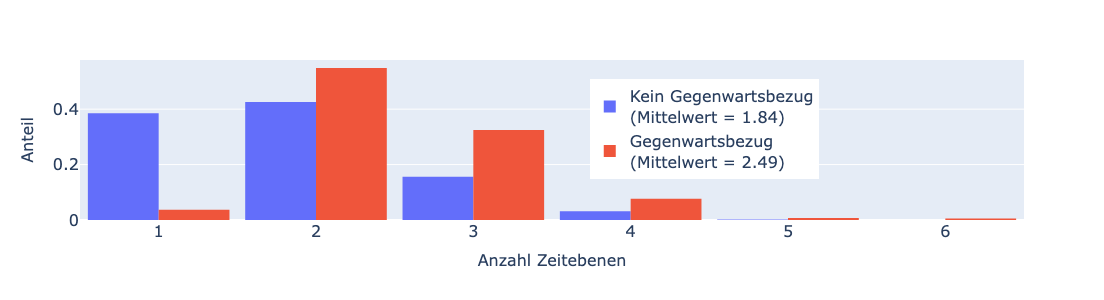

In [57]:
meta_plot = meta_anth_bin.copy()

for cont_comp_feature in results_filtered.index:
    mean_main = meta_plot[meta_plot[main_feature] == 1][cont_comp_feature].mean()
    mean_notmain = meta_plot[meta_plot[main_feature] == 0][cont_comp_feature].mean()
    label_main = f"Gegenwartsbezug<br>(Mittelwert = {round(mean_main, 2)})"
    label_notmain = f"Kein Gegenwartsbezug<br>(Mittelwert = {round(mean_notmain, 2)})"
    meta_plot['plot_legend'] = [label_main if x == 1 else label_notmain for x in meta_plot[main_feature]]
        
    fig = px.histogram(
        meta_plot,
        x = cont_comp_feature,
        color = 'plot_legend',
        histnorm = 'probability density',
        barmode = 'group',
        labels = {'plot_legend' : '', 'zeitebenen' : 'Anzahl Zeitebenen',}
    )

    fig.update_layout(
        width = 700, height = 300,
        yaxis_title="Anteil",
        xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
        legend=dict(font = dict(size=16), x=0.54, y = 0.88),
        bargap=0.1
    )
    # fig.write_image(f"plots/6.6 Gegenwartsbezug – {cont_comp_feature}.pdf")
    fig.show()

In [58]:
result_categories = ['wenn_nicht', 'wenn_ja', 'mannwhitneyu_p', 'pointbiserialr_corr',]

results_a = relations_bincont(
    meta = meta_anth_bin.query("1850 <= year <= 1884"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_b = relations_bincont(
    meta = meta_anth_bin.query("1885 <= year <= 1918"), 
    main_feature = main_feature,
    comp_features = results_filtered.index
)

results_merged = results_a[result_categories].join(
    results_b[result_categories], 
    lsuffix='_1850', rsuffix = '_1885'
)
results_merged['diff_of_corrs'] = results_merged['pointbiserialr_corr_1885'] - results_merged['pointbiserialr_corr_1850']

round(results_merged.sort_values(by = 'diff_of_corrs'), 3)

,wenn_nicht_1850,wenn_ja_1850,mannwhitneyu_p_1850,pointbiserialr_corr_1850,wenn_nicht_1885,wenn_ja_1885,mannwhitneyu_p_1885,pointbiserialr_corr_1885,diff_of_corrs
zeitebenen,1.834,2.509,0.0,0.368,1.85,2.421,0.0,0.291,-0.077
